In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

data_dir = "/Users/mac/Desktop/Study/Diploma/data"

import matplotlib.pyplot as plt

# Data Preparation

In [2]:
def return_unique(x):
    return len(x.unique())

In [24]:
gtd_path = os.path.join(data_dir, "gtd/gtd_processed")
tables = os.listdir(gtd_path)

df = pd.read_parquet(os.path.join(gtd_path, tables[3]))

print(len(df))
df.head()

2674336


,INN,value,code,product,year
0,3528000597,14478.0,56,270400.0,2008
1,3528000597,34265.0,860,720917.0,2008
2,3528000597,139697.0,428,721049.0,2008
3,3528000597,95204.0,792,722619.0,2008
4,4704012472,25562.0,380,480419.0,2008


In [3]:
spark_path = os.path.join(data_dir, "spark/cur_spark_data_v2.parquet")
ruslana_path = os.path.join(data_dir, "ruslana/ruslana.parquet")
gtd_path = os.path.join(data_dir, "gtd/gtd_processed")
iv_path = os.path.join(data_dir, "instrument/iv.parquet")

os.listdir(gtd_path)
spark_df = pd.read_parquet(spark_path)

spark_df.columns = [item.lower() for item in spark_df.columns]
            
spark_df = spark_df.loc[~spark_df["okved_four"].isin(['nan', 'None'])]
iv_df = pd.read_parquet(iv_path)\
            .assign(instrument=lambda x: x["weight"] * (x["tariff"]) / 100)\
            .assign(instrument_c=lambda x: x["weight_c"] * (x["tariff"]) / 100)

iv_df = iv_df.groupby(["okved_four", "year"])[["instrument", "instrument_c"]].sum().reset_index()

iv_df = iv_df.groupby("year").instrument_c.mean().reset_index()\
            .rename(columns={"instrument_c": "mean_c"})\
            .merge(iv_df, on=["year"], how="inner")\
            .assign(instrument_c_centered=lambda x: x["instrument_c"] - x["mean_c"])

iv_df = iv_df.groupby("year").instrument.mean().reset_index()\
            .rename(columns={"instrument": "mean"})\
            .merge(iv_df, on=["year"], how="inner")\
            .assign(instrument_centered=lambda x: x["instrument"] - x["mean"])

tables = os.listdir(gtd_path)
gtd_df = []
for table in tqdm(tables):
    df = pd.read_parquet(os.path.join(gtd_path, table))
    try:
        df = df.assign(value=lambda x: x.value.str.replace(',', '.').astype(float))
    except AttributeError:
        df = df
    df = df.loc[(df["INN"] > 100)]\
            .groupby(["INN", "year"]).agg({"code": return_unique})\
            .reset_index().rename(columns={"code": "num_countries"})
    gtd_df.append(df)
    
gtd_df = pd.concat(gtd_df)
gtd_df.columns = [item.lower() for item in gtd_df.columns]

ruslana_df = pd.read_parquet(ruslana_path)

print(len(spark_df), len(gtd_df), len(ruslana_df), len(iv_df))

df = spark_df.merge(ruslana_df, on=["inn", "year"], how="inner")
print(len(df))

df = df.merge(iv_df, on=["okved_four", "year"], how="inner")
print(len(df))

df = df.merge(gtd_df, on=["inn", "year"], how="outer")
print(len(df))

df = df.drop_duplicates(["inn", "year"])

print(len(df))

100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


2948133 139420 3946725 2390
3321815
3209793
3291294
2372698


In [4]:
values = np.log(df[(df.assets > 0.0) & (df.empl >= 5)].assets)
Q1 = values.quantile(0.25)
Q2 = values.quantile(0.75)
IQR = Q2 - Q1

print(df[df.assets > 0.0].assets.quantile([0.025, 0.975]).tolist())
print(np.exp(Q1 - 1.5 * IQR), np.exp(Q2 + 1.5 * IQR))

[10000.0, 383641749.9999993]
4496.255831512603 2896415259.275599


9.210340371976184


<Axes: >

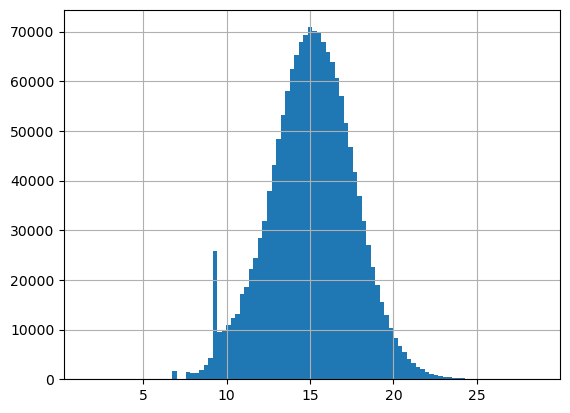

In [5]:
print(np.log(1e4))
np.log(df[(df.assets > 0.0) & (df.empl >= 5)].assets).hist(bins=100)

In [6]:
df.groupby("year").instrument.describe()

,count,mean,std,min,25%,50%,75%,max
year,,,,,,,,
2005,334602.0,0.042111,0.034686,0.0,0.022108,0.036108,0.057317,0.3195
2006,480681.0,0.038008,0.030105,0.0,0.020426,0.032095,0.050000,0.2918
2007,411007.0,0.036351,0.027266,0.0,0.020364,0.032487,0.044718,0.2636
2008,555049.0,0.043209,0.032407,0.0,0.022292,0.036328,0.058017,0.2636
2009,509858.0,0.040800,0.032063,0.0,0.016794,0.034349,0.053533,0.2636


In [7]:
values = np.log(df[(df.assets > 0.0) & (df.empl >= 5)].assets)
Q1 = values.quantile(0.25)
Q2 = values.quantile(0.75)
IQR = Q2 - Q1

left, right = np.exp(Q1 - 1.5 * IQR), np.exp(Q2 + 1.5 * IQR)
left, right = df[df.assets > 0.0].assets.quantile([0.025, 0.975]).tolist()

years = pd.DataFrame(np.arange(2004, 2010), columns=["year"])

export_data = []
for inn, item_df in tqdm(df.loc[~df.num_countries.isnull()].groupby("inn")):
    item_df = item_df.merge(years, on="year", how="right")\
                .assign(
                    inn=inn,
                    num_countries=lambda x: x.num_countries.fillna(0.0), 
                    num_countries_prev=lambda x: x.num_countries.shift(1),
                    countries_diff=lambda x: x.num_countries - x.num_countries_prev,
                    countries_diff_prev=lambda x: x.countries_diff.shift(1)
                ).dropna(subset=["inn"])

    export_data.append(item_df)

export_data = pd.concat(export_data)[["inn", "year", "num_countries_prev", "countries_diff"]]

filter_cond = (df.assets > 0.)

data = df.loc[filter_cond]\
        .sort_values(by=["inn", "year"])\
        .assign(
            short_leverage=lambda x: x.short_debt / x.assets, 
            long_leverage=lambda x: x.long_debt / x.assets, 
            leverage=lambda x: x.debt / x.assets, 
            log_assets=lambda x: np.log(x.assets),
            tangibility=lambda x: x.tang_assets / x.assets, 
            profitability=lambda x: x.revenue / x.assets
        )

print("Assets more then 0: {}".format(len(data)))

# (data["leverage"] <= 1.) &
filter_cond = (
    (data["short_leverage"] >= 0.) &
    (data["long_leverage"] >= 0.) &
    (data["leverage"] <= 1.) &
    (data.revenue > 0.0) &
    (data.assets > left) &
    (data.assets < right) &
    (data.empl >= 5.0)
)

data = data.loc[filter_cond]
print("Employees no less than 5: {}".format(len(data)))

data = data.merge(export_data, on=["inn", "year"], how="left")\
        .assign(
            num_countries_prev=lambda x: x.num_countries_prev.fillna(0.0),
            num_countries_prev_log=lambda x: np.log(1 + x.num_countries_prev),
            countries_diff=lambda x: x.countries_diff.fillna(0.0), 
            expansion=lambda x: 1 * (x.countries_diff > 0.0)
        )

data = data[data.year > 2005]

print(len(data))

data.head()

100%|██████████| 68048/68048 [01:24<00:00, 804.57it/s]


Assets more then 0: 2052267
Employees no less than 5: 1253710
1040936


,inn,okved,year,tang_assets,assets,short_debt,revenue,opex,profit,long_debt,...,short_leverage,long_leverage,leverage,log_assets,tangibility,profitability,num_countries_prev,countries_diff,num_countries_prev_log,expansion
0,101000021,47.73,2008,105000.0,115000.0,87000.0,1943000.0,NaN,76000.0,0.0,...,0.756522,0.0,0.756522,11.652687,0.913043,16.895652,0.0,0.0,0.0,0
1,101000021,47.73,2009,176000.0,186000.0,82000.0,2812000.0,NaN,119000.0,0.0,...,0.440860,0.0,0.440860,12.133502,0.946237,15.118280,0.0,0.0,0.0,0
2,101000078,74.20,2006,382000.0,387000.0,113000.0,2568000.0,NaN,314000.0,0.0,...,0.291990,0.0,0.291990,12.866180,0.987080,6.635659,0.0,0.0,0.0,0
3,101000078,74.20,2007,414000.0,593000.0,5000.0,3971000.0,NaN,542000.0,0.0,...,0.008432,0.0,0.008432,13.292950,0.698145,6.696459,0.0,0.0,0.0,0
4,101000078,74.20,2008,896000.0,1131000.0,1000.0,6211000.0,NaN,487000.0,0.0,...,0.000884,0.0,0.000884,13.938613,0.792219,5.491600,0.0,0.0,0.0,0


In [8]:
# Сохраним данные для Stata
COLS = [
    "year",
    "okved_four",
    "exporting",
    "expansion",
    "countries_diff",
    "log_assets",
    "tangibility",
    "profitability",
    "num_countries_prev_log",
    "instrument",
    "instrument_centered",
    "instrument_c",
    "instrument_c_centered",
    "leverage",
    "short_leverage",
    "long_leverage",
    "empl"
]

to_study = data.assign(exporting=lambda x: 1 * (x["num_countries"] > 0))\
    .dropna(subset=["inn"] + COLS).drop_duplicates(subset=["inn", "year"])

inns = to_study["inn"].unique()

inns = pd.DataFrame(inns, columns=["inn"])\
        .reset_index().rename(columns={"index": "firm_id"})

to_study = to_study.merge(inns, on=["inn"], how="inner")
print(len(to_study))

leverage_agg = to_study.groupby(["okved_four", "year"])[["leverage", "short_leverage", "long_leverage"]].median().reset_index()\
                .rename(columns={"leverage": "lev_median", "short_leverage": "short_lev_median", "long_leverage": "long_lev_median"})

to_study = to_study.merge(leverage_agg, on=["okved_four", "year"], how="inner")

to_study[["firm_id"] + COLS + ["lev_median", "short_lev_median", "long_lev_median"]]\
        .to_csv(os.path.join(data_dir, "testing/cur_spark_ruslana_v1_test.csv"), index=False)

627093


Text(0.5, 1.0, 'Leverage')

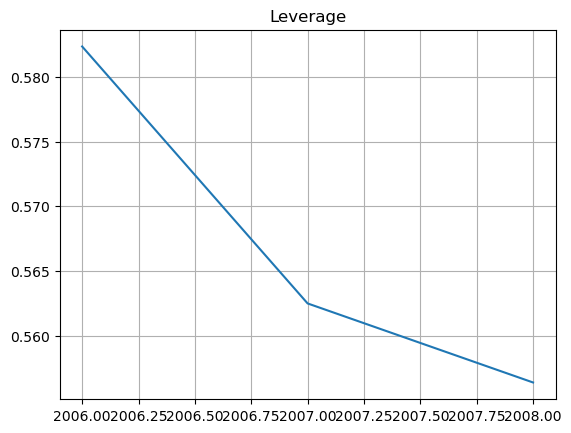

In [9]:
to_plot = to_study.groupby("year")[["leverage", "instrument", "instrument_c", "exporting", "expansion"]].mean().reset_index()

plt.plot(to_plot.year, to_plot.leverage)
plt.grid()
plt.title("Leverage")

Text(0.5, 1.0, 'Instrument')

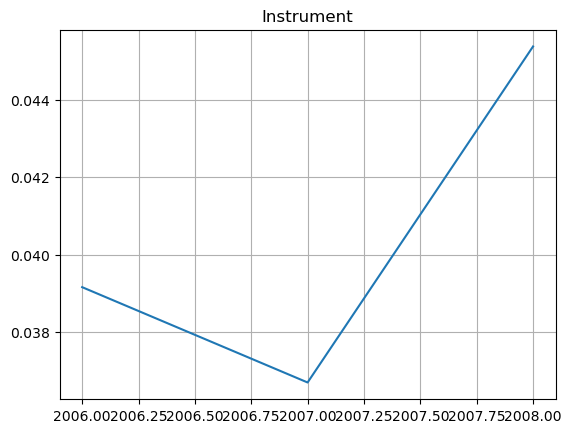

In [10]:
plt.plot(to_plot.year, to_plot.instrument)
plt.grid()
plt.title("Instrument")

Text(0.5, 1.0, 'Export')

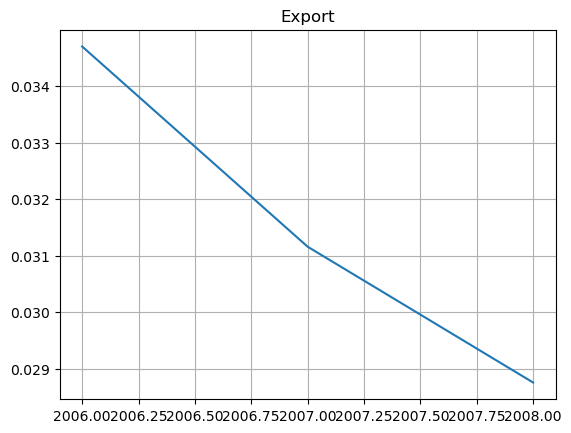

In [11]:
plt.plot(to_plot.year, to_plot.exporting)
plt.grid()
plt.title("Export")

Text(0.5, 1.0, 'Export')

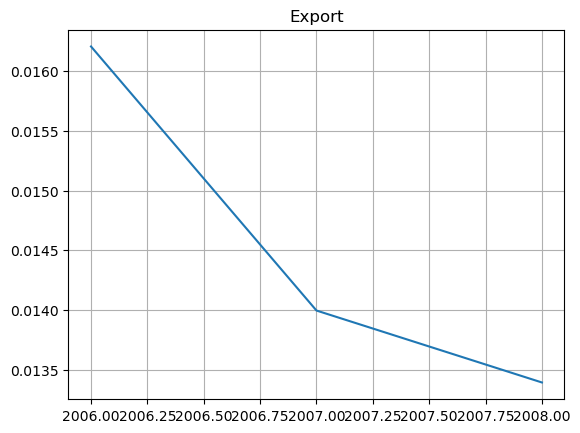

In [12]:
plt.plot(to_plot.year, to_plot.expansion)
plt.grid()
plt.title("Export")

array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

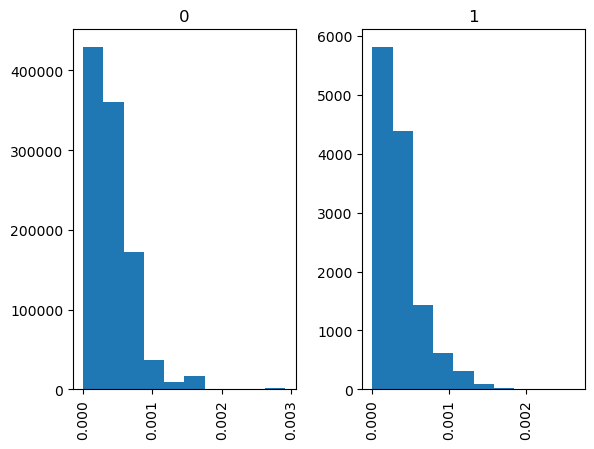

In [9]:
to_study.hist("instrument", by="expansion")

In [11]:
to_study.groupby("expansion").instrument.describe()

,count,mean,std,min,25%,50%,75%,max
expansion,,,,,,,,
0,1027832.0,-0.044259,0.032826,-0.492156,-0.055070,-0.042461,-0.033835,0.186170
1,12677.0,-0.044268,0.033579,-0.487036,-0.052177,-0.040446,-0.031902,0.161224


In [13]:
to_study.groupby("expansion").instrument_c.describe()

,count,mean,std,min,25%,50%,75%,max
expansion,,,,,,,,
0,1027832.0,-1.326382,1.103319,-18.580121,-1.980902,-1.132661,-0.440401,0.840029
1,12677.0,-1.709699,1.369518,-18.580121,-2.288210,-1.485894,-0.975338,0.840029


In [30]:
to_study[["leverage", "expansion", "exporting", "instrument", "empl"]].corr()

,leverage,expansion,exporting,instrument,empl
leverage,1.000000,0.028066,0.035581,0.122720,0.041938
expansion,0.028066,1.000000,0.654178,0.047964,0.093007
exporting,0.035581,0.654178,1.000000,0.072353,0.156714
instrument,0.122720,0.047964,0.072353,1.000000,0.030668
empl,0.041938,0.093007,0.156714,0.030668,1.000000


In [8]:
to_study.loc[to_study.expansion > 0]

,inn,okved,year,tang_assets,assets,short_debt,revenue,opex,profit,long_debt,...,leverage,log_assets,tangibility,profitability,num_countries_prev,countries_diff,num_countries_prev_log,expansion,exporting,firm_id
67,101005037,10.41.2,2006,8.720000e+05,7.132000e+06,1.787000e+06,1.061700e+07,189000.0,-816000.0,0.000000e+00,...,0.250561,15.780102,0.122266,1.488643,0.0,2.0,0.000000,1,1,26
483,105000819,28.12.1,2006,1.572580e+08,1.807470e+08,7.001700e+07,3.722700e+08,8374000.0,37565000.0,3.221000e+06,...,0.405196,19.012609,0.870045,2.059619,7.0,2.0,2.079442,1,1,197
484,105000819,28.12.1,2007,1.907950e+08,2.285800e+08,8.099400e+07,5.300040e+08,165306000.0,70746000.0,2.511000e+06,...,0.365321,19.247397,0.834697,2.318681,9.0,1.0,2.302585,1,1,197
485,105000819,28.12.1,2008,2.984070e+08,3.371930e+08,1.241040e+08,8.792350e+08,24236000.0,94020000.0,2.904000e+06,...,0.376663,19.636166,0.884974,2.607513,10.0,2.0,2.397895,1,1,197
556,105005101,28.41,2009,3.030000e+06,8.151000e+06,3.453000e+06,1.363800e+07,NaN,358000.0,2.082000e+06,...,0.679058,15.913651,0.371734,1.673169,0.0,1.0,0.000000,1,1,224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1087474,8801012066,46.77,2009,4.193910e+08,4.509770e+08,4.146970e+08,1.182400e+08,27454000.0,-1384000.0,0.000000e+00,...,0.919552,19.926927,0.929961,0.262186,2.0,1.0,1.098612,1,1,494244
1087562,8901010175,61.10.1,2009,1.127930e+08,1.625980e+08,2.805200e+07,2.588950e+08,21952000.0,7464000.0,2.373000e+06,...,0.187118,18.906791,0.693692,1.592240,0.0,1.0,0.000000,1,1,494278
1089023,8905033688,41.20,2008,1.532272e+09,2.545673e+09,1.037939e+09,2.063594e+09,232643000.0,53562000.0,1.504733e+09,...,0.998821,21.657661,0.601912,0.810628,0.0,1.0,0.000000,1,1,494925
1089382,8909001750,10.11,2008,6.797300e+07,9.480300e+07,6.691000e+07,1.297890e+08,149714000.0,-70296000.0,0.000000e+00,...,0.705779,18.367312,0.716992,1.369039,0.0,1.0,0.000000,1,1,495108


In [24]:
to_study.loc[to_study.inn == 101005037][["num_countries_prev", "num_countries"]]

,num_countries_prev,num_countries
83,0.0,2.0
84,2.0,NaN
85,0.0,NaN
86,0.0,NaN


In [10]:
to_study.loc[to_study.inn == 8909001750]

,inn,okved,year,tang_assets,assets,short_debt,revenue,opex,profit,long_debt,...,leverage,log_assets,tangibility,profitability,num_countries_prev,countries_diff,num_countries_prev_log,expansion,exporting,firm_id
1089381,8909001750,10.11,2007,58778000.0,74403000.0,71046000.0,89405000.0,10118000.0,9254000.0,0.0,...,0.954881,18.125007,0.789995,1.201632,0.0,0.0,0.000000,0,0,495108
1089382,8909001750,10.11,2008,67973000.0,94803000.0,66910000.0,129789000.0,149714000.0,-70296000.0,0.0,...,0.705779,18.367312,0.716992,1.369039,0.0,1.0,0.000000,1,1,495108
1089383,8909001750,10.11,2009,54642000.0,110061000.0,58903000.0,143085000.0,58778000.0,612000.0,0.0,...,0.535185,18.516545,0.496470,1.300052,1.0,1.0,0.693147,1,1,495108


In [11]:
to_study.loc[to_study.inn == 101005037]

,inn,okved,year,tang_assets,assets,short_debt,revenue,opex,profit,long_debt,...,leverage,log_assets,tangibility,profitability,num_countries_prev,countries_diff,num_countries_prev_log,expansion,exporting,firm_id
67,101005037,10.41.2,2006,872000.0,7132000.0,1787000.0,10617000.0,189000.0,-816000.0,0.0,...,0.250561,15.780102,0.122266,1.488643,0.0,2.0,0.000000,1,1,26
68,101005037,10.41.2,2007,10589000.0,18980000.0,14451000.0,31077000.0,345000.0,2000.0,0.0,...,0.761380,16.758896,0.557903,1.637355,2.0,-2.0,1.098612,0,0,26
69,101005037,10.41.2,2008,15360000.0,30237000.0,25706000.0,42889000.0,363000.0,11000.0,0.0,...,0.850150,17.224577,0.507987,1.418428,0.0,0.0,0.000000,0,0,26
70,101005037,10.41.2,2009,31560000.0,55664000.0,1627000.0,107965000.0,174000.0,213000.0,49495000.0,...,0.918403,17.834844,0.566973,1.939584,0.0,0.0,0.000000,0,0,26


In [26]:
iv_df

,year,mean,mean_c,okved_four,instrument,instrument_c,instrument_c_centered,instrument_centered
0,2005,0.046419,1.023526,01.11,0.066603,1.689208,0.665682,0.020184
1,2005,0.046419,1.023526,01.13,0.007350,0.260858,-0.762668,-0.039069
2,2005,0.046419,1.023526,01.16,0.050000,0.050000,-0.973526,0.003581
3,2005,0.046419,1.023526,01.19,0.035180,0.137999,-0.885526,-0.011239
4,2005,0.046419,1.023526,01.25,0.050000,0.050000,-0.973526,0.003581
...,...,...,...,...,...,...,...,...
2385,2009,0.043777,0.906250,96.01,0.005000,0.005000,-0.901250,-0.038777
2386,2009,0.043777,0.906250,96.02,0.050000,0.050000,-0.856250,0.006223
2387,2009,0.043777,0.906250,96.03,0.000000,0.000000,-0.906250,-0.043777
2388,2009,0.043777,0.906250,96.04,0.015742,0.025000,-0.881250,-0.028036


In [13]:
to_study["instrument"].describe()

count    1.090447e+06
mean     4.108011e-02
std      3.185160e-02
min      0.000000e+00
25%      2.167180e-02
50%      3.434910e-02
75%      5.486046e-02
max      2.918000e-01
Name: instrument, dtype: float64

In [15]:
(to_study.instrument == 0).sum()

np.int64(14287)

<Axes: >

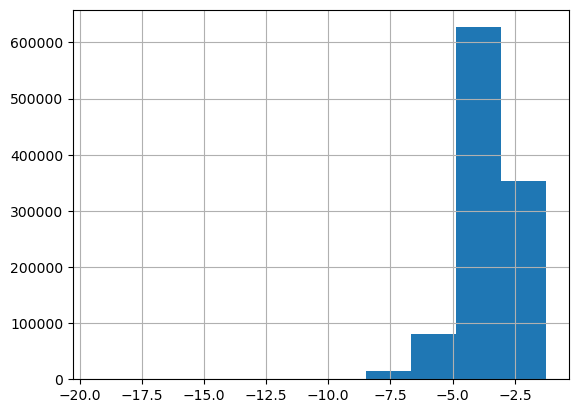

In [14]:
np.log(to_study.loc[to_study.instrument > 0]["instrument"]).hist()

In [17]:
to_study.groupby(["okved_four", "year"]).exporting.sum().reset_index().sort_values(by="exporting")

,okved_four,year,exporting
1911,96.09,2009,0
1757,77.40,2007,0
1375,47.29,2009,0
1746,77.34,2008,0
1744,77.34,2006,0
...,...,...,...
1351,46.90,2009,467
1319,46.69,2009,475
1350,46.90,2008,528
1348,46.90,2006,547


In [43]:
test_df = df.groupby(["okved_four", "year"]).num_countries.sum().reset_index().sort_values(by="num_countries")

print(test_df.shape)
bad_okved_list = test_df.loc[(test_df.num_countries == 0) & (test_df.year == 2005)]\
            .sort_values(by=["year", "okved_four"]).okved_four.astype(float).tolist()

print(len(to_study))
to_study.loc[to_study.okved_four.astype(float).isin(bad_okved_list)]

(2390, 3)
1090447


,inn,okved,year,tang_assets,assets,short_debt,revenue,opex,profit,long_debt,...,leverage,log_assets,tangibility,profitability,num_countries_prev,countries_diff,num_countries_prev_log,expansion,exporting,firm_id
773,105023380,59.13,2008,1.270000e+05,2.957000e+06,7.100000e+04,1.590000e+05,NaN,1000.0,0.0,...,0.024011,14.899686,0.042949,0.053771,0.0,0.0,0.0,0,0,303
774,105023380,59.13,2009,1.120000e+05,2.921000e+06,3.400000e+04,3.020000e+05,NaN,1000.0,0.0,...,0.011640,14.887437,0.038343,0.103389,0.0,0.0,0.0,0,0,303
9400,263011757,33.20,2008,2.480000e+05,2.480000e+05,9.600000e+04,2.205000e+06,NaN,273000.0,0.0,...,0.387097,12.421184,1.000000,8.891129,0.0,0.0,0.0,0,0,4202
9401,263011757,33.20,2009,4.040000e+05,1.072000e+06,6.460000e+05,2.159000e+06,NaN,167000.0,0.0,...,0.602612,13.885037,0.376866,2.013993,0.0,0.0,0.0,0,0,4202
9407,263012221,59.13,2008,4.136000e+06,8.212000e+06,3.900000e+05,3.390000e+05,NaN,0.0,0.0,...,0.047491,15.921107,0.503653,0.041281,0.0,0.0,0.0,0,0,4207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1085916,8617001665,42.13,2007,2.058899e+09,2.652344e+09,1.787837e+09,4.421670e+09,1.394401e+09,419558000.0,13609000.0,...,0.679190,21.698710,0.776256,1.667080,0.0,0.0,0.0,0,0,493597
1088812,8905025140,33.20,2006,1.131900e+07,1.721500e+07,9.557000e+06,2.781800e+07,6.575000e+06,1473000.0,0.0,...,0.555155,16.661292,0.657508,1.615916,0.0,0.0,0.0,0,0,494846
1088813,8905025140,33.20,2007,1.533200e+07,2.101700e+07,1.188600e+07,4.170000e+07,3.980000e+05,594000.0,0.0,...,0.565542,16.860842,0.729505,1.984108,0.0,0.0,0.0,0,0,494846
1088814,8905025140,33.20,2008,1.138900e+07,1.634600e+07,6.621000e+06,4.863300e+07,2.440000e+05,1347000.0,0.0,...,0.405053,16.609494,0.696745,2.975223,0.0,0.0,0.0,0,0,494846


In [31]:
to_study.loc[to_study.okved_four == "38.22"]

,inn,okved,year,tang_assets,assets,short_debt,revenue,opex,profit,long_debt,...,leverage,log_assets,tangibility,profitability,num_countries_prev,countries_diff,num_countries_prev_log,expansion,exporting,firm_id
14101,273052512,38.22,2006,1150000.0,2434000.0,2159000.0,13005000.0,74000.0,208000.0,0.0,...,0.887017,14.705047,0.472473,5.343057,0.0,0.0,0.0,0,0,6298
14102,273052512,38.22,2009,13655000.0,15265000.0,14464000.0,42577000.0,128000.0,-85000.0,0.0,...,0.947527,16.541073,0.894530,2.789191,0.0,0.0,0.0,0,0,6298
66174,1649010395,38.22,2006,9225000.0,13712000.0,5453000.0,38917000.0,4895000.0,-502000.0,0.0,...,0.397681,16.433782,0.672768,2.838171,0.0,0.0,0.0,0,0,29483
66175,1649010395,38.22,2007,9178000.0,13734000.0,6839000.0,47587000.0,1395000.0,6234000.0,0.0,...,0.497961,16.435385,0.668269,3.464905,0.0,0.0,0.0,0,0,29483
66176,1649010395,38.22,2008,12387000.0,18935000.0,9186000.0,80407000.0,2182000.0,13173000.0,0.0,...,0.485133,16.756523,0.654185,4.246475,0.0,0.0,0.0,0,0,29483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1075585,7842353916,38.22,2008,7570296.0,9374231.0,8308592.0,34500000.0,2081488.0,183736.0,0.0,...,0.886323,16.053475,0.807564,3.680302,0.0,0.0,0.0,0,0,489016
1075586,7842353916,38.22,2009,20257000.0,21082000.0,19833000.0,67738000.0,43000.0,816000.0,0.0,...,0.940755,16.863930,0.960867,3.213073,0.0,0.0,0.0,0,0,489016
1077716,8403001604,38.22,2009,93008000.0,96107000.0,88134000.0,133420000.0,19179000.0,14006000.0,0.0,...,0.917040,18.380973,0.967755,1.388244,0.0,0.0,0.0,0,0,490023
1077974,8506006019,38.22,2007,7553000.0,8478000.0,8362000.0,10373000.0,61000.0,-32000.0,0.0,...,0.986318,15.952985,0.890894,1.223520,0.0,0.0,0.0,0,0,490146


# Inbox

In [20]:
iv_path = os.path.join(data_dir, "instrument/iv.parquet")
iv_df = pd.read_parquet(iv_path)\
        .assign(instrument=lambda x: x["weight"] * x["tariff"])

# 32.20
iv_df.loc[iv_df.okved_four == "38.22"]

,okved_four,product,code,year,value,weight,weight_c,tariff,prev_tariff,tariff_diff,instrument
225870,38.22,280461.0,804,2005,1307.0,1.0,1.0,5.0,NaN,NaN,5.0
225871,38.22,280461.0,804,2006,1307.0,1.0,1.0,5.0,5.0,0.0,5.0
225872,38.22,280461.0,804,2007,1307.0,1.0,1.0,5.0,5.0,0.0,5.0
225873,38.22,280461.0,804,2008,1307.0,1.0,1.0,5.0,5.0,0.0,5.0
225874,38.22,280461.0,804,2009,1307.0,1.0,1.0,5.0,5.0,0.0,5.0


Text(0.5, 1.0, 'Average Tariffs')

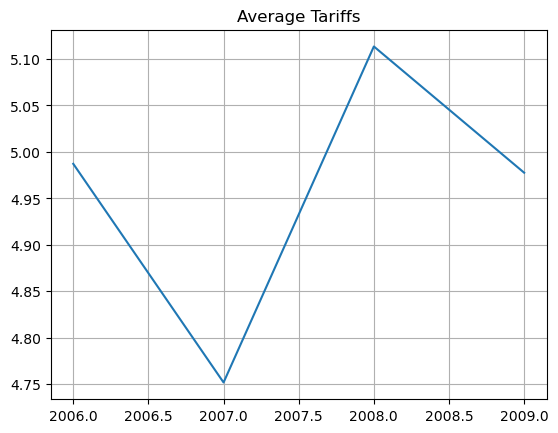

In [22]:
to_plot = iv_df.loc[iv_df.year > 2005].groupby("year").tariff.mean().reset_index()

plt.plot(to_plot.year, to_plot.tariff)
plt.grid()
plt.title("Average Tariffs")

In [25]:
np.sort(res.assign(tariff_diff=lambda x: x.tariff - x.prev_tariff)["tariff_diff"].unique())

array([-110.  ,  -89.67,  -72.75, ...,   52.5 ,   65.  ,     nan],
      shape=(1659,))

In [11]:
iv_df.dropna().groupby(["okved_four", "year"]).weight_c.sum().reset_index().sort_values(by="weight_c")[-20:]

,okved_four,year,weight_c
565,20.15,2005,83.0
566,20.15,2006,83.0
567,20.15,2007,83.0
568,20.15,2008,83.0
569,20.15,2009,83.0
489,17.12,2009,89.0
488,17.12,2008,89.0
485,17.12,2005,89.0
486,17.12,2006,89.0
487,17.12,2007,89.0


In [13]:
iv_df.loc[iv_df.tariff.isnull()]

,okved_four,product,code,year,value,weight,weight_c,tariff,instrument


In [18]:
len(iv_df) / 5

99369.0

In [29]:
iv_df[iv_df["product"] == 480593.0]

,okved_four,product,code,year,value,weight,weight_c,tariff,instrument
8705,17.12,480593.0,31,2005,57640.0,0.000070,0.013809,15.0,0.001043
8706,17.12,480593.0,31,2006,57640.0,0.000070,0.013809,15.0,0.001043
8707,17.12,480593.0,31,2007,57640.0,0.000070,0.013809,15.0,0.001043
8708,17.12,480593.0,31,2008,57640.0,0.000070,0.013809,15.0,0.001043
8709,17.12,480593.0,31,2009,57640.0,0.000070,0.013809,15.0,0.001043
...,...,...,...,...,...,...,...,...,...
508695,17.12,480593.0,887,2005,53989.0,0.000065,0.061866,NaN,NaN
508696,17.12,480593.0,887,2006,53989.0,0.000065,0.061866,5.0,0.000326
508697,17.12,480593.0,887,2007,53989.0,0.000065,0.061866,5.0,0.000326
508698,17.12,480593.0,887,2008,53989.0,0.000065,0.061866,5.0,0.000326


In [6]:
iv_df = pd.read_parquet(iv_path)\
        .assign(
            instrument=lambda x: x["weight"] * x["tariff"],
            instrument_c=lambda x: x["weight_c"] * x["tariff"]
        )

iv_df = iv_df.groupby(["okved_four", "year"]).agg({"instrument": "sum", "instrument_c": "sum"}).reset_index()

iv_df[["instrument", "instrument_c"]]

,instrument,instrument_c
0,6.531415,165.269472
1,6.510063,164.502044
2,3.664837,90.207875
3,7.241544,145.591073
4,7.242238,140.857554
...,...,...
2392,3.039873,7.163211
2393,3.039873,7.163211
2394,3.039873,7.163211
2395,3.039873,7.163211


In [10]:
iv_df = pd.read_parquet(iv_path)\
        .assign(
            instrument=lambda x: x["weight"] * x["tariff"],
            instrument_c=lambda x: x["weight_c"] * x["tariff"]
        )

df_agg = iv_df.loc[iv_df.year == 2005].groupby(["okved_four"]).value.sum().reset_index()

iv_df = iv_df.merge(df_agg, on=["okved_four"], how="inner")\
        .assign(weights_corrected=lambda x: x.value_x / x.value_y)

print(len(iv_df) / 5)
iv_df.groupby(["okved_four", "year"]).weights_corrected.sum().idxmax()

70000.0


('20.41', np.int64(2005))

In [11]:
len(iv_df.loc[iv_df.tariff.isnull()]) / 5

1543.0

In [35]:
iv_df.loc[iv_df.okved_four == "32.20"]

,okved_four,product,code,year,value_x,weight,weight_c,tariff,instrument,instrument_c,value_y,weights_corrected
43282,32.20,854389.0,392,2005,1967.0,0.047829,1.0,0.0,0.000000,0.0,41126.0,0.047829
43283,32.20,920410.0,276,2005,36355.0,0.883991,1.0,3.7,3.270765,3.7,41126.0,0.883991
43284,32.20,920930.0,804,2005,2804.0,0.068181,1.0,15.0,1.022711,15.0,41126.0,0.068181
144245,32.20,854389.0,392,2006,1967.0,0.047829,1.0,0.0,0.000000,0.0,41126.0,0.047829
144246,32.20,920410.0,276,2006,36355.0,0.883991,1.0,3.7,3.270765,3.7,41126.0,0.883991
144247,32.20,920930.0,804,2006,2804.0,0.068181,1.0,10.0,0.681807,10.0,41126.0,0.068181
244770,32.20,920930.0,804,2007,2804.0,0.068181,1.0,10.0,0.681807,10.0,41126.0,0.068181
343758,32.20,920930.0,804,2008,2804.0,0.068181,1.0,10.0,0.681807,10.0,41126.0,0.068181
441567,32.20,920930.0,804,2009,2804.0,0.068181,1.0,10.0,0.681807,10.0,41126.0,0.068181


In [44]:
iv_df.loc[iv_df.okved_four == "41.10"]

,okved_four,product,code,year,value_x,weight,weight_c,tariff,instrument,instrument_c,value_y,weights_corrected
46183,41.10,210610.0,804,2005,10500.0,0.033992,0.033992,NaN,NaN,NaN,10500.0,1.000000
147166,41.10,210610.0,804,2006,10500.0,0.033992,0.033992,10.0,0.339916,0.339916,10500.0,1.000000
247632,41.10,210610.0,804,2007,10500.0,0.033992,0.033992,10.0,0.339916,0.339916,10500.0,1.000000
247633,41.10,262190.0,804,2007,298400.0,0.966008,0.966008,2.0,1.932017,1.932017,10500.0,28.419048
346562,41.10,210610.0,804,2008,10500.0,0.033992,0.033992,10.0,0.339916,0.339916,10500.0,1.000000
346563,41.10,262190.0,804,2008,298400.0,0.966008,0.966008,2.0,1.932017,1.932017,10500.0,28.419048
444357,41.10,210610.0,804,2009,10500.0,0.033992,0.033992,4.0,0.135966,0.135966,10500.0,1.000000
444358,41.10,262190.0,804,2009,298400.0,0.966008,0.966008,2.0,1.932017,1.932017,10500.0,28.419048


In [ ]:
tariffs_path = os.path.join(data_dir, "instrument/tariffs.parquet")
w_path = os.path.join(data_dir, "instrument/weights.parquet")

tariffs_df = pd.read_parquet(tariffs_path)
weights_df = pd.read_parquet(w_path)\
                .assign(ProductCode=lambda x: x.product.astype(int))

tariffs_df = tariffs_df.merge(weights_df, on=[""])

years = pd.DataFrame(np.arange(2005, 2010), columns=["Year"])

result_df = []
for _, item_df in tqdm(tariffs_df.groupby(["Reporter_ISO_N", "ProductCode"])):
    item_df = item_df.merge(years, on="Year", how="right")\
                .assign(SimpleAverage=item_df["SimpleAverage"].ffill())
    result_df.append(item_df)

result_df = pd.concat(result_df)

100%|██████████| 937772/937772 [09:16<00:00, 1684.60it/s] 


In [52]:
pd.read_parquet(w_path)

,okved_four,product,code,value,weight,weight_c
0,01.11,10110.0,804,5770.0,0.000277,0.020314
1,01.11,10190.0,804,31101.0,0.001495,0.109495
2,01.11,10210.0,496,7881.0,0.000379,0.953193
3,01.11,10410.0,496,387.0,0.000019,0.046807
4,01.11,30212.0,156,2750.0,0.000132,0.008326
...,...,...,...,...,...,...
102559,96.09,700992.0,428,2572.0,0.022189,1.000000
102560,96.09,720449.0,156,38112.0,0.328798,0.352429
102561,96.09,730210.0,156,43669.0,0.376739,0.403815
102562,96.09,732690.0,156,8655.0,0.074668,0.080034


In [49]:
item_df

,NomenCode,Reporter_ISO_N,Year,ProductCode,SimpleAverage,country,current_year
0,H2,918,2005,970600,NaN,EUN,2005
1,H2,918,2006,970600,NaN,EUN,2006
2,H3,918,2007,970600,NaN,EUN,2007
3,H3,918,2008,970600,NaN,EUN,2008
4,H3,918,2009,970600,NaN,EUN,2009


In [48]:
result_df.loc[(result_df["Reporter_ISO_N"] == 918) & (result_df.ProductCode == 920410)]

,NomenCode,Reporter_ISO_N,Year,ProductCode,SimpleAverage,country,current_year
0,H2,918.0,2005,920410.0,NaN,EUN,2005.0
1,H2,918.0,2006,920410.0,NaN,EUN,2006.0


In [41]:
tariffs_df.loc[(tariffs_df["Reporter_ISO_N"] == 918) & (tariffs_df.ProductCode == 920410)]

,NomenCode,Reporter_ISO_N,Year,ProductCode,SimpleAverage,country,current_year
1325740,H2,918,2005,920410,3.7,EUN,2005
1330964,H2,918,2006,920410,3.7,EUN,2006
